## Load Packages and Data

In [2]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import os, sys
import random
random.seed(a=8, version=2)

import numpy as np
import argparse

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import scipy
import skimage 
from scipy.ndimage import shift 

from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

import time

sys.path.insert(1, '..')
from deep_learning_techniques import networks

IMG_WIDTH = 2000
IMG_HEIGHT = 1520
IMG_CHANNELS = 1

sys.path.insert(1, '.')

data_dir = "../datasets/Teflon/"

def normalise(data):
    return (data - data.min())/(data.max() - data.min())

X_data = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_data = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Here the 180 images are loaded into numpy arrays with shape (180, 1024, 1024, 1)
# For each 1024 by 1024 matrix, each element in the matrix corresponds to the pixel value in the .tif image
# Load 1mm images into X_data
i = 75
i_str = "0000"[len(str(i)):] + str(i)
img_x = imread((data_dir + 'Plastic_4_holes_1m/SAMPLE_T' + i_str + '.tif'), as_gray=True)[:,:]  
print(img_x.shape)
img_x = img_x[560:2080, 280:2280]
img_x = normalise(img_x)

img_y = imread((data_dir + 'PLastic_4_holes/SAMPLE_T' + i_str + '.tif'), as_gray=True)[:,:] 
img_y = img_y[560:2080, 280:2280]
img_y = normalise(img_y)

/home/mfre190/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/mfre190/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:293: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  plugin_module = __import__('skimage.io._plugins.' + modname,


(2160, 2560)


In [3]:
print(tf.__version__)

2.6.2


In [4]:
print(skimage.__version__)

0.19.2


"""
Created on Thu Jan 11 11:13:17 2018

@author: Thomas Li
"""

from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ma

 

def plot(image):
    sns.set_style("dark")
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    return 0

 

inputName = np.array(["Darks_", "Flats_start_", "Flats_end_"])
Darks = io.imread(inputName[0] + "Average.tif")
Flats_start = io.imread(inputName[1] + "Average.tif")
Flats_end = io.imread(inputName[2] + "Average.tif")

 

fileName = "a_NoGrid_"
outputName = "Linear_proj_"
startIndex = 61
endIndex = 3662

 

totalNum = endIndex - startIndex

 

ind = str(startIndex)
while len(str(ind))<4:
    ind = "0" + str(ind)

 

maxval = 2**16 - 1 # Assume a 16 bits detector

 

for ind in range(startIndex,endIndex):
    if ind%100 == 0:
        print(ind)
    ratio = (ind-startIndex)/(endIndex-startIndex-1)
    index = str(ind)
    while len(index)<4:
        index = "0" + str(index)
    OutputImage = np.array(io.imread(fileName + index + ".tif"), dtype='float32')
    OutputImage = ma.masked_outside(OutputImage, 1, maxval-1)
    OutputImage = (OutputImage - Darks)/(Flats_end*ratio + Flats_start*(1-ratio) - Darks)
    avg_clip = ma.min(OutputImage)
    OutputImage = OutputImage.astype(np.float32).filled(avg_clip).clip(avg_clip)
    io.imsave(outputName + index + ".tif", OutputImage)

## Rigid Registration

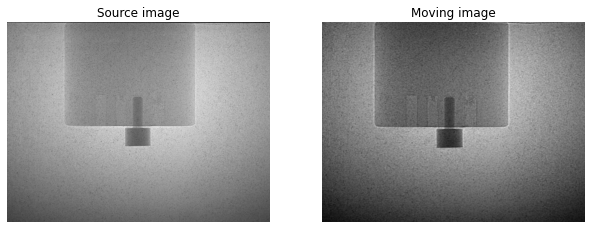

In [5]:
source_im = img_x
moving_im = img_y 

fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
# ax3 = plt.subplot(1, 3, 3) 

ax1.imshow(source_im, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Source image') 

ax2.imshow(moving_im, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Moving image')

# ax3.imshow(pred_im, cmap='gray')
# ax3.set_axis_off()
# ax3.set_title('Pred image') 

plt.show()

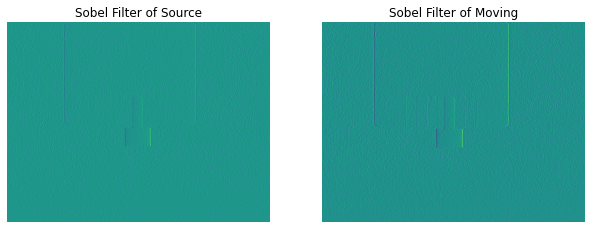

In [6]:
# Apply Sobel to ephasize geometry
sobel1 = scipy.ndimage.sobel(source_im) 
sobel2 = scipy.ndimage.sobel(moving_im) 

fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)

ax1.imshow(sobel1)
ax1.set_axis_off()
ax1.set_title('Sobel Filter of Source') 

ax2.imshow(sobel2)
ax2.set_axis_off()
ax2.set_title('Sobel Filter of Moving')

plt.show()

In [7]:
# Registration using the mean x & y components of the flow generated via iterative Lucas-Kanade (iLK) technique
flow = skimage.registration.optical_flow_ilk(sobel1, sobel2) 
flow_x = flow[0, :, :]
flow_y = flow[1, :, :] 
x_off = np.mean(flow_x) 
y_off = np.mean(flow_y) 
corrected_im = shift(moving_im, shift = (-x_off, -y_off), mode = "constant")

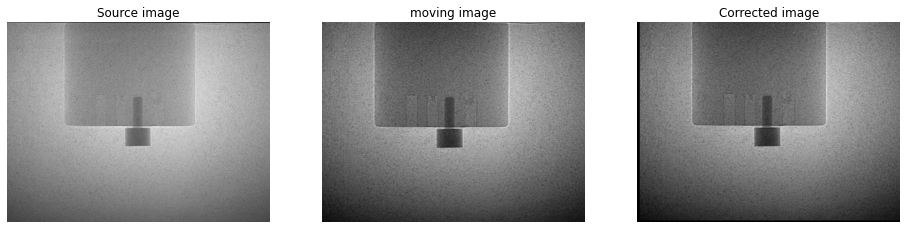

In [8]:
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3) 

ax1.imshow(source_im, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Source image') 

ax2.imshow(moving_im, cmap='gray')
ax2.set_axis_off()
ax2.set_title('moving image')

ax3.imshow(corrected_im, cmap='gray')
ax3.set_axis_off()
ax3.set_title('Corrected image')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


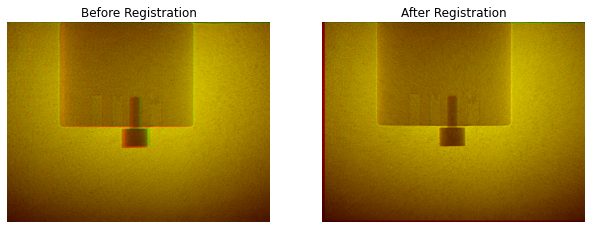

In [9]:
rgb1 = np.zeros((*source_im.shape, 3)) 
rgb1[:, :, 0] = source_im 
rgb1[:, :, 1] = moving_im 

rgb2 = np.zeros((*source_im.shape, 3))  
rgb2[:, :, 0] = source_im 
rgb2[:, :, 1] = corrected_im 

fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)

ax1.imshow(rgb1)
ax1.set_axis_off()
ax1.set_title('Before Registration') 

ax2.imshow(rgb2)
ax2.set_axis_off()
ax2.set_title('After Registration')

plt.show()

In [10]:
saved_corrected_im = np.load("/hpc/mfre190/narrow_unet/datasets/Teflon/Registered_plastic_4_holes/SAMPLE_T0075.tif.npy")

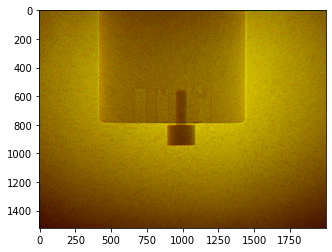

In [11]:
rgb3 = np.zeros((*source_im.shape, 3)) 
rgb3[:, :, 0] = source_im
rgb3[:, :, 1] = normalise(saved_corrected_im[560:2080, 280:2280])
plt.imshow(rgb3)

## Deep Phase Retrieval 

In [12]:
model = tf.keras.models.load_model('../models/narrow-unet-teflon1656147219')

2022-06-26 16:01:45.791143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 16:01:45.820002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 16:01:45.820341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 16:01:45.821734: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

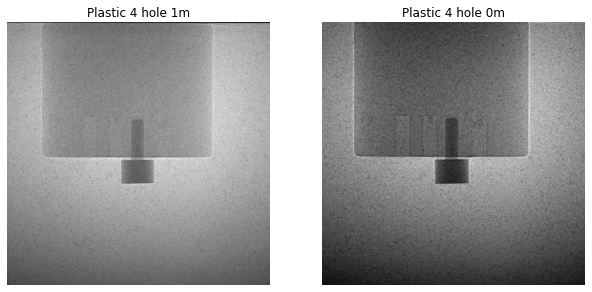

In [13]:
img_x = imread((data_dir + 'Plastic_4_holes_1m/SAMPLE_T' + i_str + '.tif'), as_gray=True)[:,:] 
x = img_x[np.newaxis, 560:2096, 512:2048, np.newaxis] 
x = normalise(x)  

img_y = np.load(data_dir + f"Registered_plastic_4_holes/SAMPLE_T{i_str}.tif.npy") 
y_true = img_y[560:2096, 512:2048] 
y_true = normalise(y_true)

fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)

ax1.imshow(x[0], cmap='gray')
ax1.set_axis_off()
ax1.set_title('Plastic 4 hole 1m') 

ax2.imshow(y_true, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Plastic 4 hole 0m')

plt.show()

In [14]:
y_pred = model.predict(x)

2022-06-26 16:01:55.148305: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-26 16:01:55.860928: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400
2022-06-26 16:01:57.399199: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-26 16:01:57.399253: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-26 16:01:57.831671: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying t

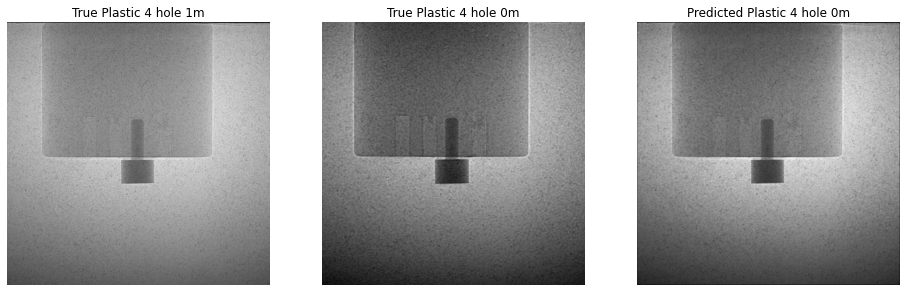

In [15]:
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1) 
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(x[0], cmap='gray')
ax1.set_axis_off()
ax1.set_title('True Plastic 4 hole 1m') 

ax2.imshow(y_true, cmap='gray')
ax2.set_axis_off()
ax2.set_title('True Plastic 4 hole 0m') 

ax3.imshow(y_pred[0], cmap='gray')
ax3.set_axis_off()
ax3.set_title('Predicted Plastic 4 hole 0m') 

plt.show()